In [1]:
!pip install conllu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# imports
import conllu
import numpy as np
from tqdm import tqdm

import transformers
from sklearn.model_selection import train_test_split as split


import torch
from transformers import AdamW, get_scheduler
from transformers import BertModel
import io
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup
import random
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt




import wandb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef,
    classification_report)
import pandas as pd


from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data import

In [5]:
# load the conllu dataset
#with open("../data/dataset.conllu") as f:
with open("/content/drive/MyDrive/06_TUWien/09_NLP/data/dataset.conllu") as f:
    data = conllu.parse(f.read())

In [6]:
# extract headlines (since a headline can have more than one sentence)
headlines = []
for i, sentence in enumerate(data):
    if sentence.metadata["sent_id"] == "0":
        headlines.append(data[i:i+1])
    else:
        headlines[-1].append(sentence)

In [7]:
#train test validation split
SEED = 42
tr_data, other_data = split(headlines, test_size=0.3, random_state=SEED)
val_data, ts_data = split(other_data, test_size=0.5, random_state=SEED)

In [8]:
print(len(tr_data))
print(len(val_data))
print(len(ts_data))

20033
4293
4293


In [9]:
def extract_data(headlines):
    texts = []
    labels = []

    # Extract text and labels
    for headline in headlines:
        text = headline[0].metadata['text']
        label = int(headline[0].metadata['class'])

        texts.append(text)
        labels.append(label)

    return texts, labels

tr_texts, tr_labels = extract_data(tr_data)
val_texts, val_labels = extract_data(val_data)
ts_texts, ts_labels = extract_data(ts_data)

#### Data prep

In [11]:
# Initialize the BERT tokenizer
pretrained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name, do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Function to encode the text for BERT (convert text to input_ids and attention_masks)
def encode_data(texts, tokenizer):

    # Tokenize the text using BERT tokenizer
    encoding = tokenizer.batch_encode_plus(
        texts,
        max_length=16,
        truncation = True,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding=True)

    input_ids = encoding['input_ids']  # Remove batch dimension
    attention_masks = encoding['attention_mask']  # Remove batch dimension

    return torch.tensor(input_ids), torch.tensor(attention_masks)

# Prepare the tokenized data for training and testing
tr_tokens, tr_atention = encode_data(tr_texts, tokenizer)
val_tokens, val_atention = encode_data(val_texts, tokenizer)
ts_tokens, ts_atention = encode_data(ts_texts, tokenizer)

In [71]:
batch_size = 32
# Function to encode the text for BERT (convert text to input_ids and attention_masks)
def dataloader(tokens, masks, labels, batch_size = 16, isTrain = False):

    dataset = TensorDataset(tokens,masks, torch.tensor(labels))
    if isTrain == "True":
        trainloader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = True, drop_last=True)
    else:
        trainloader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = False, drop_last=True)

    return trainloader

# Prepare the tokenized data for training and testing
train = dataloader(tr_tokens, tr_atention, tr_labels, batch_size, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, batch_size)
test = dataloader(ts_tokens, ts_atention, ts_labels, batch_size)

In [13]:
# Custom Dataset class, to store raw sentences
class SarcasmDataset(Dataset):
    def __init__(self, tokens, masks, labels, sentences):
        self.tokens = tokens
        self.masks = masks
        self.labels = labels
        self.sentences = sentences

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokens[idx],
            "attention_mask": self.masks[idx],
            "label": self.labels[idx],
            "sentence": self.sentences[idx]
        }


def dataloader(tokens, masks, labels, sentences, batch_size=16,  isTrain = False):

    dataset = SarcasmDataset(tokens, masks, torch.tensor(labels), sentences)

    if isTrain == "True":
        trainloader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = True, drop_last=True)
    else:
        trainloader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = False, drop_last=True)


    return trainloader

# Prepare the tokenized data and raw sentences
train = dataloader(tr_tokens, tr_atention, tr_labels, tr_texts, batch_size=32, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, val_texts, batch_size=32)
test = dataloader(ts_tokens, ts_atention, ts_labels, ts_texts, batch_size=32)

#### Model setup

In [16]:
class bert_for_sarcasm(nn.Module):
    def __init__(self, input_model, linear1=256, linear2=128, drop=0.25, mod_type='binary', bert_model='bert-base-uncased'):
        super(bert_for_sarcasm, self).__init__()
        self.mod_type = mod_type
        self.bert_model = bert_model

        # Set model size based on BERT type
        self.model_size = 768 if bert_model == 'bert-base-uncased' else 1024
        self.input_model = input_model

        # Fully connected layers
        self.linear = nn.Linear(self.model_size, linear1)
        self.linear2 = nn.Linear(linear1, linear2)
        self.linear3_binary = nn.Linear(linear2, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Dropout layer
        self.dropout = nn.Dropout(drop)

    def forward(self, input_values, attention_mask):
        # Pass through BERT
        _, output = self.input_model(input_values, attention_mask=attention_mask).values()

        # Fully connected layers with dropout and activation
        output = self.linear(output)
        output = self.dropout(output)
        output = self.relu(output)

        #check if this is needed
        output = self.linear2(output)
        output = self.dropout(output)
        output = self.relu(output)

        # Binary classification output
        output = self.linear3_binary(output)
        output = self.sigmoid(output)

        return output




In [18]:
class bert_for_sarcasm_simplified(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', dropout=0.2):
        super(bert_for_sarcasm_simplified, self).__init__()

        # Load pre-trained BERT model
        self.bert_encoder = BertModel.from_pretrained(bert_model)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer after BERT output (first layer size: 128)
        self.dense = nn.Linear(self.bert_encoder.config.hidden_size, 128)

        # ReLU activation
        self.relu = nn.ReLU()

        # Output layer (binary classification)
        self.output = nn.Linear(128, 1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Pass input through BERT encoder to get the embeddings
        bert_output = self.bert_encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the CLS token (first token) output
        cls_output = bert_output.last_hidden_state[:, 0, :]

        # Apply dense layer and ReLU activation
        x = self.dense(cls_output)
        x = self.relu(x)

        # Apply dropout
        x = self.dropout(x)

        # Output layer for binary classification
        x = self.output(x)

        # Sigmoid activation for final output
        output = self.sigmoid(x)

        return output


In [20]:
# Initialize WandB
wandb.init(
    project="sarcasm-detection",
    config={
        "epochs": 5,
        "batch_size": 32,
        "learning_rate": 2e-5,
        "scheduler": "linear",
        "loss_function": "BCELoss"
    }
)

# Training function with progress tracking, early stopping, and WandB logging
def train_bert(model, trainloader, validationloader, device, epochs=10, patience=3):
    # Move model to device
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Scheduler
    total_training_steps = len(trainloader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * total_training_steps, num_training_steps=total_training_steps)

    # Loss function
    loss_function = nn.BCELoss()

    # Track best validation accuracy and early stopping
    best_validation_accuracy = 0.0
    best_model_state = None
    no_improvement_epochs = 0

    # Metrics for WandB logging
    running_validation_loss = []
    running_training_loss = []
    validation_acc = []
    training_acc = []

    print(f"Starting training for {epochs} epochs with early stopping (patience={patience}).")

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # Training phase
        model.train()
        total_loss = 0
        correct_predictions = 0

        with tqdm(trainloader, desc="Training", unit="batch") as train_progress:

          for batch in train_progress:
              # Extract batch data
              input_ids = batch["input_ids"]
              attention_mask = batch["attention_mask"]
              labels = batch["label"]
              raw_sentences = batch["sentence"]

              inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = model(inputs, attention_mask).squeeze()

              # Compute loss
              loss = loss_function(outputs, labels.float())
              loss.backward()

              optimizer.step()
              scheduler.step()

              total_loss += loss.item()

              # Calculate accuracy
              outputs = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
              correct_predictions += (outputs == labels).sum().item()

              # Update progress bar
              train_progress.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(trainloader.dataset)
        avg_train_accuracy = correct_predictions / len(trainloader.dataset)
        running_training_loss.append(avg_train_loss)
        training_acc.append(avg_train_accuracy)

        print(f"Total loss: {total_loss:.4f}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")

        # Log training metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_accuracy": avg_train_accuracy
        })

        # Validation phase
        validation_accuracy, validation_loss = validate_bert(model, validationloader, loss_function, device)
        running_validation_loss.append(validation_loss)
        validation_acc.append(validation_accuracy)

        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Log validation metrics to WandB
        wandb.log({
            "epoch": epoch,
            "val_loss": validation_loss,
            "val_accuracy": validation_accuracy
        })

        # Check for early stopping
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_model_state = model.state_dict()  # Save the best model state
            no_improvement_epochs = 0
            print("Validation accuracy improved. Best model updated.")
            # Save best model weights to WandB
            torch.save(model.state_dict(), "best_model.pth")
            wandb.save("best_model.pth")
        else:
            no_improvement_epochs += 1
            print(f"No improvement in validation for {no_improvement_epochs} consecutive epoch(s).")

        if no_improvement_epochs >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    # Restore the best model state (if early stopping was triggered)
    if best_model_state:
        model.load_state_dict(best_model_state)

    print("Training completed.")
    return best_validation_accuracy, running_validation_loss, running_training_loss, validation_acc, training_acc


# Validation function
def validate_bert(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():

        for batch in tqdm(dataloader, desc="Validation", unit="batch"):
            # Extract batch data
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]
            raw_sentences = batch["sentence"]

            inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(inputs, attention_mask).squeeze()

            # Compute loss
            loss = loss_function(outputs, labels.float())
            total_loss += loss.item()

            # Calculate accuracy
            outputs = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
            correct_predictions += (outputs == labels).sum().item()

    accuracy = correct_predictions / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader.dataset)

    return accuracy, avg_loss



def test_bert(model, testloader, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []
    sentences = []

    # Loss function
    loss_function = nn.BCELoss()

    with torch.no_grad():

        for batch in tqdm(testloader, desc="Testing", unit="batch"):
            # Extract batch data
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]
            raw_sentences = batch["sentence"]

            inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)


            # Model outputs probabilities (sigmoid applied)
            outputs = model(inputs, attention_mask).squeeze()

            # Compute loss
            loss = loss_function(outputs, labels.float())
            total_loss += loss.item()

            # Store labels and predictions
            probabilities = outputs.cpu().numpy()
            predictions = (outputs >= 0.5).float().cpu().numpy()  # Convert to binary predictions
            labels = labels.cpu().numpy()

            all_probabilities.extend(probabilities)
            all_predictions.extend(predictions)
            all_labels.extend(labels)
            sentences.extend(raw_sentences)


    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probabilities)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    # Log results to WandB
    wandb.log({
        "test_loss": total_loss / len(testloader.dataset),
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
        "test_roc_auc": roc_auc,
        "test_mcc": mcc,
    })

    # Create a DataFrame
    df = pd.DataFrame({
        "True Label": all_labels,
        "Predicted Label": all_predictions,
        "Probability": all_probabilities,
        "Sentences": sentences
    })

    # Print metrics
    print("\nTest Metrics:")
    print(f"Loss: {total_loss / len(testloader.dataset):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Return all metrics
    return {
        "loss": total_loss / len(testloader.dataset),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "mcc": mcc,
        "confusion_matrix": cm,
        "df": df
    }


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovsvc (ovsvc-tu-wien). Use `wandb login --relogin` to force relogin


In [42]:
def plot_metrics(val_loss, train_loss, val_acc, train_acc):
    # Create a figure and axis
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
    plt.plot(val_loss, label='Validation Loss', color='blue', linestyle='--', marker='o')
    plt.plot(train_loss, label='Training Loss', color='red', linestyle='-', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
    plt.plot(val_acc, label='Validation Accuracy', color='blue', linestyle='--', marker='o')
    plt.plot(train_acc, label='Training Accuracy', color='red', linestyle='-', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


#### Evaluate using simple architecture

In [21]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = bert_for_sarcasm_simplified()


best_acc, val_loss, train_loss, val_acc, train_acc = train_bert(
    model=model,
    trainloader=train,
    validationloader=validation,
    device="cuda",
    epochs=10,
    patience=3
)

print(f"Best Validation Accuracy: {best_acc:.4f}")

Starting training for 10 epochs with early stopping (patience=3).

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 255.7695, Training Loss: 0.0128, Training Accuracy: 0.8095


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0075, Validation Accuracy: 0.9029
Validation accuracy improved. Best model updated.

Epoch 2/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 112.1666, Training Loss: 0.0056, Training Accuracy: 0.9303


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0077, Validation Accuracy: 0.9103
Validation accuracy improved. Best model updated.

Epoch 3/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 57.0768, Training Loss: 0.0028, Training Accuracy: 0.9689


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0094, Validation Accuracy: 0.9101
No improvement in validation for 1 consecutive epoch(s).

Epoch 4/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 29.5885, Training Loss: 0.0015, Training Accuracy: 0.9855


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0086, Validation Accuracy: 0.9185
Validation accuracy improved. Best model updated.

Epoch 5/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 17.5790, Training Loss: 0.0009, Training Accuracy: 0.9923


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0114, Validation Accuracy: 0.9101
No improvement in validation for 1 consecutive epoch(s).

Epoch 6/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 11.2541, Training Loss: 0.0006, Training Accuracy: 0.9953


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0107, Validation Accuracy: 0.9199
Validation accuracy improved. Best model updated.

Epoch 7/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 7.9323, Training Loss: 0.0004, Training Accuracy: 0.9969


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0105, Validation Accuracy: 0.9248
Validation accuracy improved. Best model updated.

Epoch 8/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 4.6046, Training Loss: 0.0002, Training Accuracy: 0.9985


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0119, Validation Accuracy: 0.9210
No improvement in validation for 1 consecutive epoch(s).

Epoch 9/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 4.5538, Training Loss: 0.0002, Training Accuracy: 0.9983


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0118, Validation Accuracy: 0.9201
No improvement in validation for 2 consecutive epoch(s).

Epoch 10/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 3.2412, Training Loss: 0.0002, Training Accuracy: 0.9988


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0121, Validation Accuracy: 0.9210
No improvement in validation for 3 consecutive epoch(s).
Early stopping triggered. Stopping training.
Training completed.
Best Validation Accuracy: 0.9248


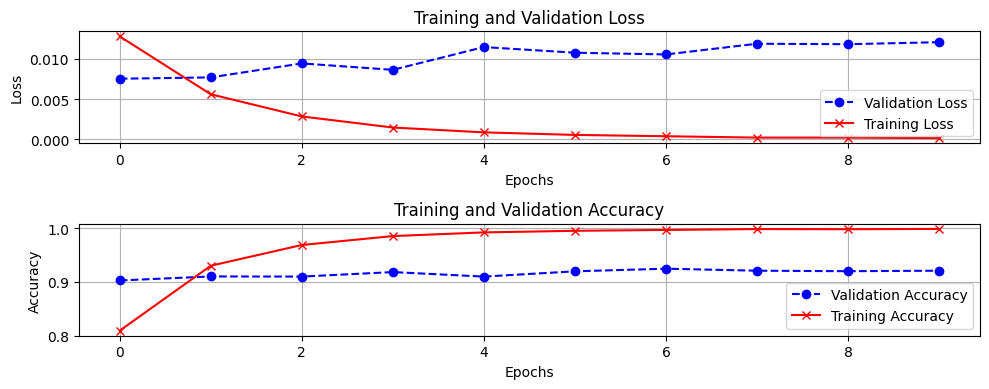

In [45]:
plot_metrics(val_loss, train_loss, val_acc, train_acc)

In [23]:
model.load_state_dict(torch.load("/content/BERT_best_model_simplified.pth"))
model.to(device)
test_metrics = test_bert(model, test, device)

# Access specific metrics
#print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
#print(f"Confusion Matrix:\n{test_metrics['confusion_matrix']}")

<ipython-input-23-597cf44861c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/BERT_best_model_simplified.pth"))


Testing:   0%|          | 0/134 [00:00<?, ?batch/s]


Test Metrics:
Loss: 0.0107
Accuracy: 0.9237
Precision: 0.9202
Recall: 0.9207
F1-Score: 0.9205
ROC-AUC: 0.9758
MCC: 0.8472
Confusion Matrix:
[[2069  164]
 [ 163 1892]]


In [25]:
df = test_metrics["df"]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4288 entries, 0 to 4287
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   True Label       4288 non-null   int64  
 1   Predicted Label  4288 non-null   float32
 2   Probability      4288 non-null   float32
 3   Sentences        4288 non-null   object 
dtypes: float32(2), int64(1), object(1)
memory usage: 100.6+ KB


In [26]:
mismatched_df = df[df['True Label'] != df['Predicted Label']]
mismatched_df

,True Label,Predicted Label,Probability,Sentences
11,1,0.0,0.001895,desperate hillary to obama: 'next vote wins'
17,0,1.0,0.861160,new york times editorial board endorses john k...
21,0,1.0,0.995343,morocco cracks down on journalists
64,0,1.0,0.998215,early apple computer sells for almost $1 milli...
72,0,1.0,0.998993,massive filament snakes across sun's surface
...,...,...,...,...
4160,1,0.0,0.000590,rising star john kerry's stirring speech paves...
4194,0,1.0,0.900739,pope condemns violence against women
4214,1,0.0,0.001204,fantasy baseball team suffers major setback as...
4220,1,0.0,0.001123,is your privacy being violated?


#### Evaluate using more complex architecture

In [30]:
model_c = bert_for_sarcasm(input_model=bert_model)


best_acc_c, val_loss_c, train_loss_c, val_acc_c, train_acc_c = train_bert(
    model=model_c,
    trainloader=train,
    validationloader=validation,
    device="cuda",  # or "cpu" if no GPU available
    epochs=10,
    patience=3
)

print(f"Best Validation Accuracy: {best_acc_c:.4f}")

Starting training for 10 epochs with early stopping (patience=3).

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 295.8815, Training Loss: 0.0148, Training Accuracy: 0.7605


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0078, Validation Accuracy: 0.8982
Validation accuracy improved. Best model updated.

Epoch 2/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 116.9046, Training Loss: 0.0058, Training Accuracy: 0.9295


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0081, Validation Accuracy: 0.9110
Validation accuracy improved. Best model updated.

Epoch 3/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 57.1227, Training Loss: 0.0029, Training Accuracy: 0.9696


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0084, Validation Accuracy: 0.9171
Validation accuracy improved. Best model updated.

Epoch 4/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 30.8235, Training Loss: 0.0015, Training Accuracy: 0.9851


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0104, Validation Accuracy: 0.9131
No improvement in validation for 1 consecutive epoch(s).

Epoch 5/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 16.1611, Training Loss: 0.0008, Training Accuracy: 0.9932


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0107, Validation Accuracy: 0.9206
Validation accuracy improved. Best model updated.

Epoch 6/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 9.8682, Training Loss: 0.0005, Training Accuracy: 0.9960


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0105, Validation Accuracy: 0.9241
Validation accuracy improved. Best model updated.

Epoch 7/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 6.4189, Training Loss: 0.0003, Training Accuracy: 0.9971


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0112, Validation Accuracy: 0.9238
No improvement in validation for 1 consecutive epoch(s).

Epoch 8/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 5.1578, Training Loss: 0.0003, Training Accuracy: 0.9976


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0116, Validation Accuracy: 0.9259
Validation accuracy improved. Best model updated.

Epoch 9/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 2.7399, Training Loss: 0.0001, Training Accuracy: 0.9993


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0120, Validation Accuracy: 0.9283
Validation accuracy improved. Best model updated.

Epoch 10/10


Training:   0%|          | 0/626 [00:00<?, ?batch/s]

Total loss: 1.8885, Training Loss: 0.0001, Training Accuracy: 0.9992


Validation:   0%|          | 0/134 [00:00<?, ?batch/s]

Validation Loss: 0.0125, Validation Accuracy: 0.9269
No improvement in validation for 1 consecutive epoch(s).
Training completed.
Best Validation Accuracy: 0.9283


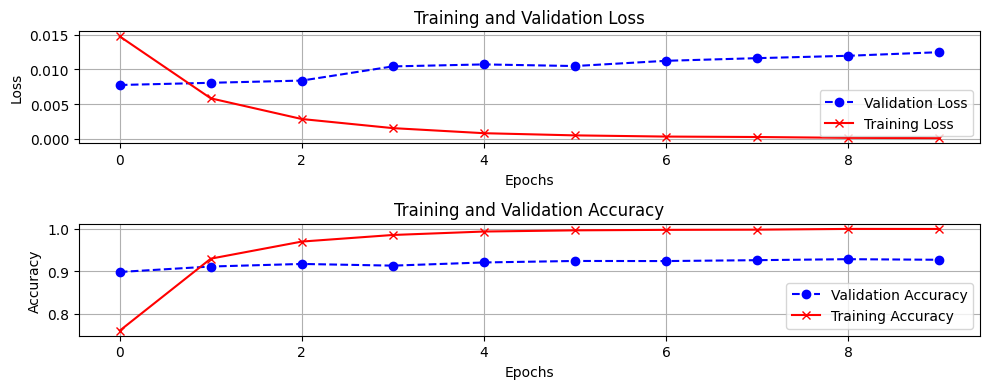

In [44]:
plot_metrics(val_loss_c, train_loss_c, val_acc_c, train_acc_c)

A bit overfit
check:
- learning rate
- loss function
- then perform errors analysis

In [31]:
model_c.load_state_dict(torch.load("/content/BERT_best_model_complex.pth"))
model_c.to(device)
test_metrics_c = test_bert(model_c, test, device)

<ipython-input-31-eefdfcee178f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_c.load_state_dict(torch.load("/content/BERT_best_model_complex.pth"))


Testing:   0%|          | 0/134 [00:00<?, ?batch/s]


Test Metrics:
Loss: 0.0124
Accuracy: 0.9272
Precision: 0.9237
Recall: 0.9246
F1-Score: 0.9241
ROC-AUC: 0.9756
MCC: 0.8542
Confusion Matrix:
[[2076  157]
 [ 155 1900]]


In [33]:
df_c = test_metrics_c["df"]

In [34]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4288 entries, 0 to 4287
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   True Label       4288 non-null   int64  
 1   Predicted Label  4288 non-null   float32
 2   Probability      4288 non-null   float32
 3   Sentences        4288 non-null   object 
dtypes: float32(2), int64(1), object(1)
memory usage: 100.6+ KB


In [35]:
mismatched_df_c = df_c[df_c['True Label'] != df_c['Predicted Label']]
mismatched_df_c

,True Label,Predicted Label,Probability,Sentences
21,0,1.0,0.994745,morocco cracks down on journalists
59,1,0.0,0.325728,mayor daley's son appointed head of illinois n...
64,0,1.0,0.998793,early apple computer sells for almost $1 milli...
72,0,1.0,0.999628,massive filament snakes across sun's surface
73,1,0.0,0.450583,investors remind mark zuckerberg he can't fuck...
...,...,...,...,...
4160,1,0.0,0.000135,rising star john kerry's stirring speech paves...
4194,0,1.0,0.965008,pope condemns violence against women
4214,1,0.0,0.004432,fantasy baseball team suffers major setback as...
4220,1,0.0,0.000138,is your privacy being violated?


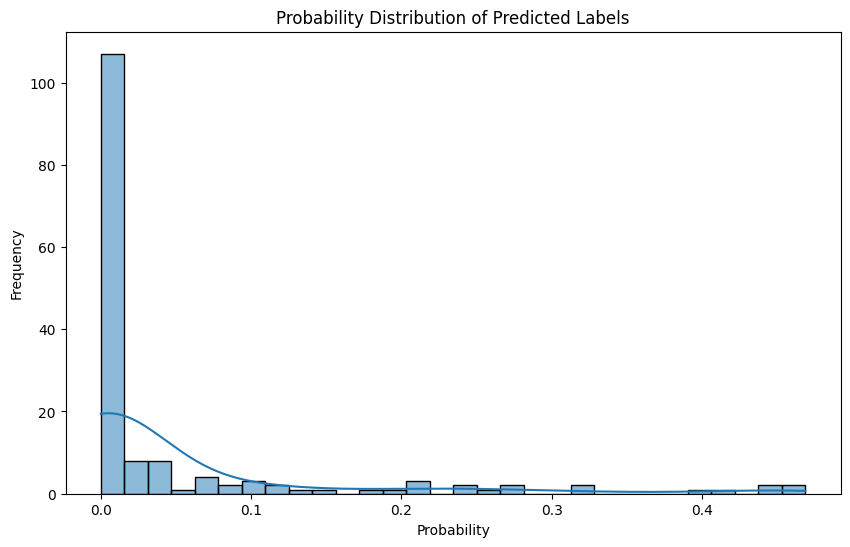

In [55]:
import seaborn as sns

# Create the probability distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(mismatched_df_c[mismatched_df_c['True Label']== 1.0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Predicted Labels')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


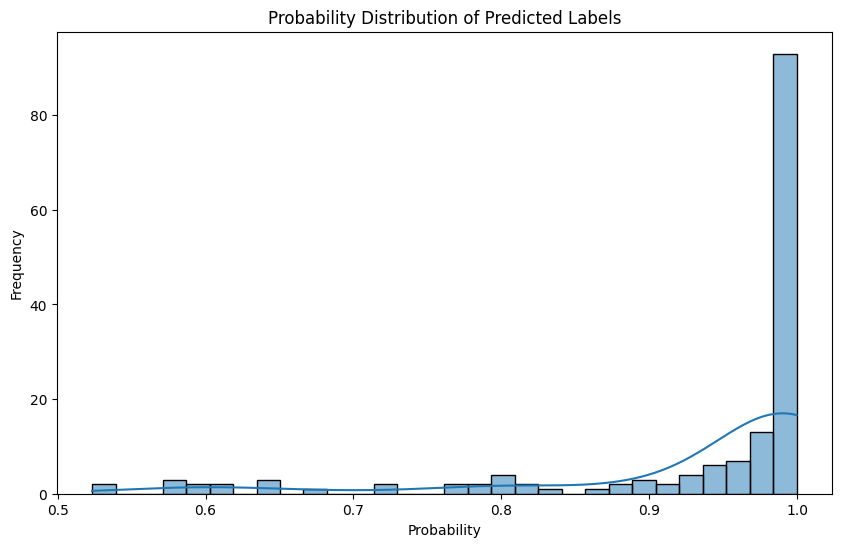

In [54]:
import seaborn as sns

# Create the probability distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(mismatched_df_c[mismatched_df_c['True Label']== 0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Predicted Labels')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [58]:
mismatched_df_c['sentence_length'] = mismatched_df_c['Sentences'].apply(lambda x: len(x.split()))
df_c['sentence_length'] = df_c['Sentences'].apply(lambda x: len(x.split()))

<ipython-input-58-a33048463ed0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_df_c['sentence_length'] = mismatched_df_c['Sentences'].apply(lambda x: len(x.split()))


In [56]:
# prompt: describe sentence length in mismathed df for predicted 1 and predicted 0 separately

# Assuming mismatched_df_c is already defined as in your provided code.

# Describe sentence length for true label 1
print("Description of sentence length for True Label 1:")
print(mismatched_df_c[mismatched_df_c['True Label'] == 1.0]['sentence_length'].describe())

# Describe sentence length for true label 0
print("\nDescription of sentence length for True Label 0:")
print(mismatched_df_c[mismatched_df_c['True Label'] == 0.0]['sentence_length'].describe())

Description of sentence length for True Label 1:
count    155.000000
mean       9.580645
std        3.736223
min        1.000000
25%        7.000000
50%        9.000000
75%       12.000000
max       22.000000
Name: sentence_length, dtype: float64

Description of sentence length for True Label 0:
count    157.000000
mean       9.057325
std        2.762482
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       18.000000
Name: sentence_length, dtype: float64


In [60]:
print("Description of sentence length for True Label 1:")
print(df_c[df_c['Predicted Label'] == 1.0]['sentence_length'].describe())

# Describe sentence length for true label 0
print("\nDescription of sentence length for True Label 0:")
print(df_c[df_c['Predicted Label'] == 0.0]['sentence_length'].describe())

Description of sentence length for True Label 1:
count    2057.000000
mean       10.187652
std         3.558814
min         1.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        23.000000
Name: sentence_length, dtype: float64

Description of sentence length for True Label 0:
count    2231.000000
mean        9.623487
std         3.003117
min         1.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        23.000000
Name: sentence_length, dtype: float64


Misclass cases mostly have high probability score meaning that model was certain that the sentance belongs to predicted class

#### Misclass analysis